## Table of Contents

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IPL-UV/ee_ipl_uv/blob/master/examples/multitemporal_cloud_masking_sample.ipynb)

1. [Automatic selection of previous cloud-free images](#Automatic-selection-of-previous-cloud-free-images)
1. [Precomputed cloud mask for Estimation](#Precomputed-cloud-mask-for-Estimation)
1. [Fitting the model and predicting the background](#Fitting-the-model-and-predicting-the-background)
 1. [Kernel Ridge Regression Model](#Kernel-Ridge-Regression-Model)
 1. [Linear Ridge Model](#Linear-Ridge-Model)
1. [Clustering the differences to create the cloud mask](#Clustering-the-differences-to-create-the-cloud-mask)
 1. [Cloud Mask visualization](#Cloud-Mask-visualization)
 1. [Comparison with *fmask* cloud mask](#Comparison-with-fmask-cloud-mask)

In [ ]:
# # To be run in google colab.
!pip install git+https://github.com/IPL-UV/ee_ipl_uv#egg=ee_ipl_uv
!earthengine authenticate

# Cloud masking of multitemporal remote sensing images

This notebook shows an example of the implementation of the method for multitemporal cloud masking and estimation of a cloud-free image proposed in [Gómez-Chova et al. 2017](http://dx.doi.org/10.1117/1.JRS.11.015005) using the [google earth engine](https://earthengine.google.com/) (GEE) platform and illustrated for the Landsat-8 image collection.
The Google's cloud infrastructure contains a multi-petabyte catalog of satellite imagery from well-known satellites which include Landsat, Sentinels and MODIS among others. In addition, it provides an Application Programming Interface (API) in JavaScript and Python to access, operate and visualize such data into an easy and scalable manner.  

Therefore, the convenience of the platform is twofold: (1) it permits to access to the a vast satellite imagery without downloading it using the same syntax regardless of the satellite, and (2) the computational burden of training the model and prediction is done on the GEE parallel distributed platform, which automatically performs an efficient memory management and distributes the processing power on virtual machines avoiding concurrency problems, which commonly arise in the context of high data volume processing.

**Summary of the cloud detection and estimation module implemented in GEE:**

We have used the Python API to implement the linear and kernel ridge regression models in GEE. For each Landsat image to process, the module first builds a cloud-free dataset by searching among the Landsat image collection for a particular location and given period of time. The cloud-free images from the time series are automatically selected using the cloud probability calculated from the Landsat BQA band. Secondly, it fits the model and predicts the background cloud-free image. Then, it computes the difference between the acquired and predicted images and performs a clustering using the difference image to create the final cloud mask.

Therefore, for the illustrative example showed bellow, the input to our algorithm will be a Landsat 8 image together with a region of interest where we want to: (1) detect the clouds and (2) predict a cloud-free/background image. The algorithm is mainly divided in three parts:

1. Automatic selection of previous cloud-free images for the region of interest. 
3. Fitting the model and predicting the background of the image.
4. Clustering the differences between the real and the estimated images to create the cloud mask.

The GEE potential was tested by processing the years 2015 and 2016 for a region of interest using the same implementation showed bellow only for an image from the Landsat 8 catalogue. Results of the processed time series are shown [here](http://isp.uv.es/projects/cdc/GEE_cloud_detection_results.html).

For any reference to this work, please cite the following paper: [Gómez-Chova et al. 2017](http://dx.doi.org/10.1117/1.JRS.11.015005).


## Automatic selection of previous cloud-free images for the region of interest

### Set up

First, we need to initialize the GEE and import some functions. Then, we need to select an image to process from the Landsat 8 catalogue and also define a polygon which encloses our region of interest.

In [1]:
import ee

from datetime import datetime
from IPython.display import Image, display

from ee_ipl_uv import multitemporal_cloud_masking
from ee_ipl_uv import download
from ee_ipl_uv import time_series_operations
from ee_ipl_uv import time_series_show
from ee_ipl_uv import predefined_cloud_algorithms
from ee_ipl_uv import converters
from ee_ipl_uv import image_wrapper

ee.Initialize()

# Select image to remove clouds
image_index = "LC08_199032_20150826"
image_collection_name = 'LANDSAT/LC08/C01/T1_TOA/'
image_predict_clouds = ee.Image(image_collection_name+image_index)
bands_original = image_predict_clouds.bandNames().getInfo()

# Select region of interest
pol = [[-0.50262451171875,39.39269330108945],
 [-0.267791748046875,39.38526381099777],
 [-0.26092529296875,39.54005788576377],
 [-0.501251220703125,39.53793974517628],
 [-0.50262451171875,39.39269330108945]]

region_of_interest = ee.Geometry.Polygon(pol)

In [2]:
# This will be hided (see metadata)
class Caption():
    num_figure = 1
    def __init__(self,s):
        self.s = s
        self.current_number = Caption.num_figure
        Caption.num_figure = Caption.num_figure+1 
    def _repr_html_(self):
        return '<center>Figure {0}. {1}</center>'.format(self.current_number,self.s)
        
    

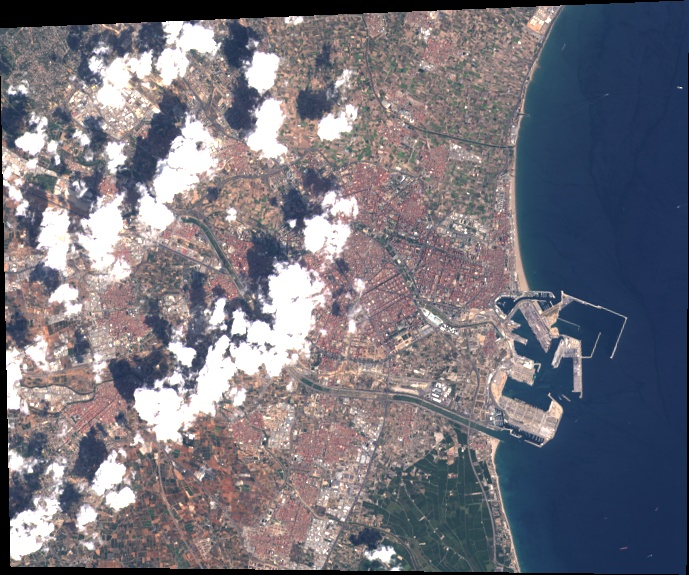

In [3]:
# Show image
image_file_original = download.MaybeDownloadThumb(image_predict_clouds.clip(region_of_interest),
                                                  params={"max":.3,"bands":"B4,B3,B2"})
display(Image(image_file_original),Caption('Clipped landsat 8 TOA image '+
                                           datetime.utcfromtimestamp(image_predict_clouds.get("system:time_start").getInfo()/1000).strftime("%Y-%m-%d %H:%M:%S")+
                                           ' over region of interest'))

## Automatic selection of previous cloud-free images

For each image of interest, we need to select a number (e.g. n=3) of past cloud-free images from the time series in order to build the model. The image of interest is $X_t \in \mathbb{R}(p \times B)$, where $p \equiv \text{number of pixels}$ and $B \equiv \text{number of bands}$ and the final input dataset is $X = [X_t,X_{t-1},X_{t-2},X_{t-3}]$, $X \in \mathbb{R}(p \times 4 \cdot B)$, where we define $X_{t-j}$ being  the $j$th previous image to $t$ without clouds. 

### Inspection of cloud cover from the previous images
We inspect the previous images using the `PreviousImagesWithCC` function, which provides the cloud cover over the region of interest computed from the Quality Assessment band (QABand) that is included within the Landsat image.

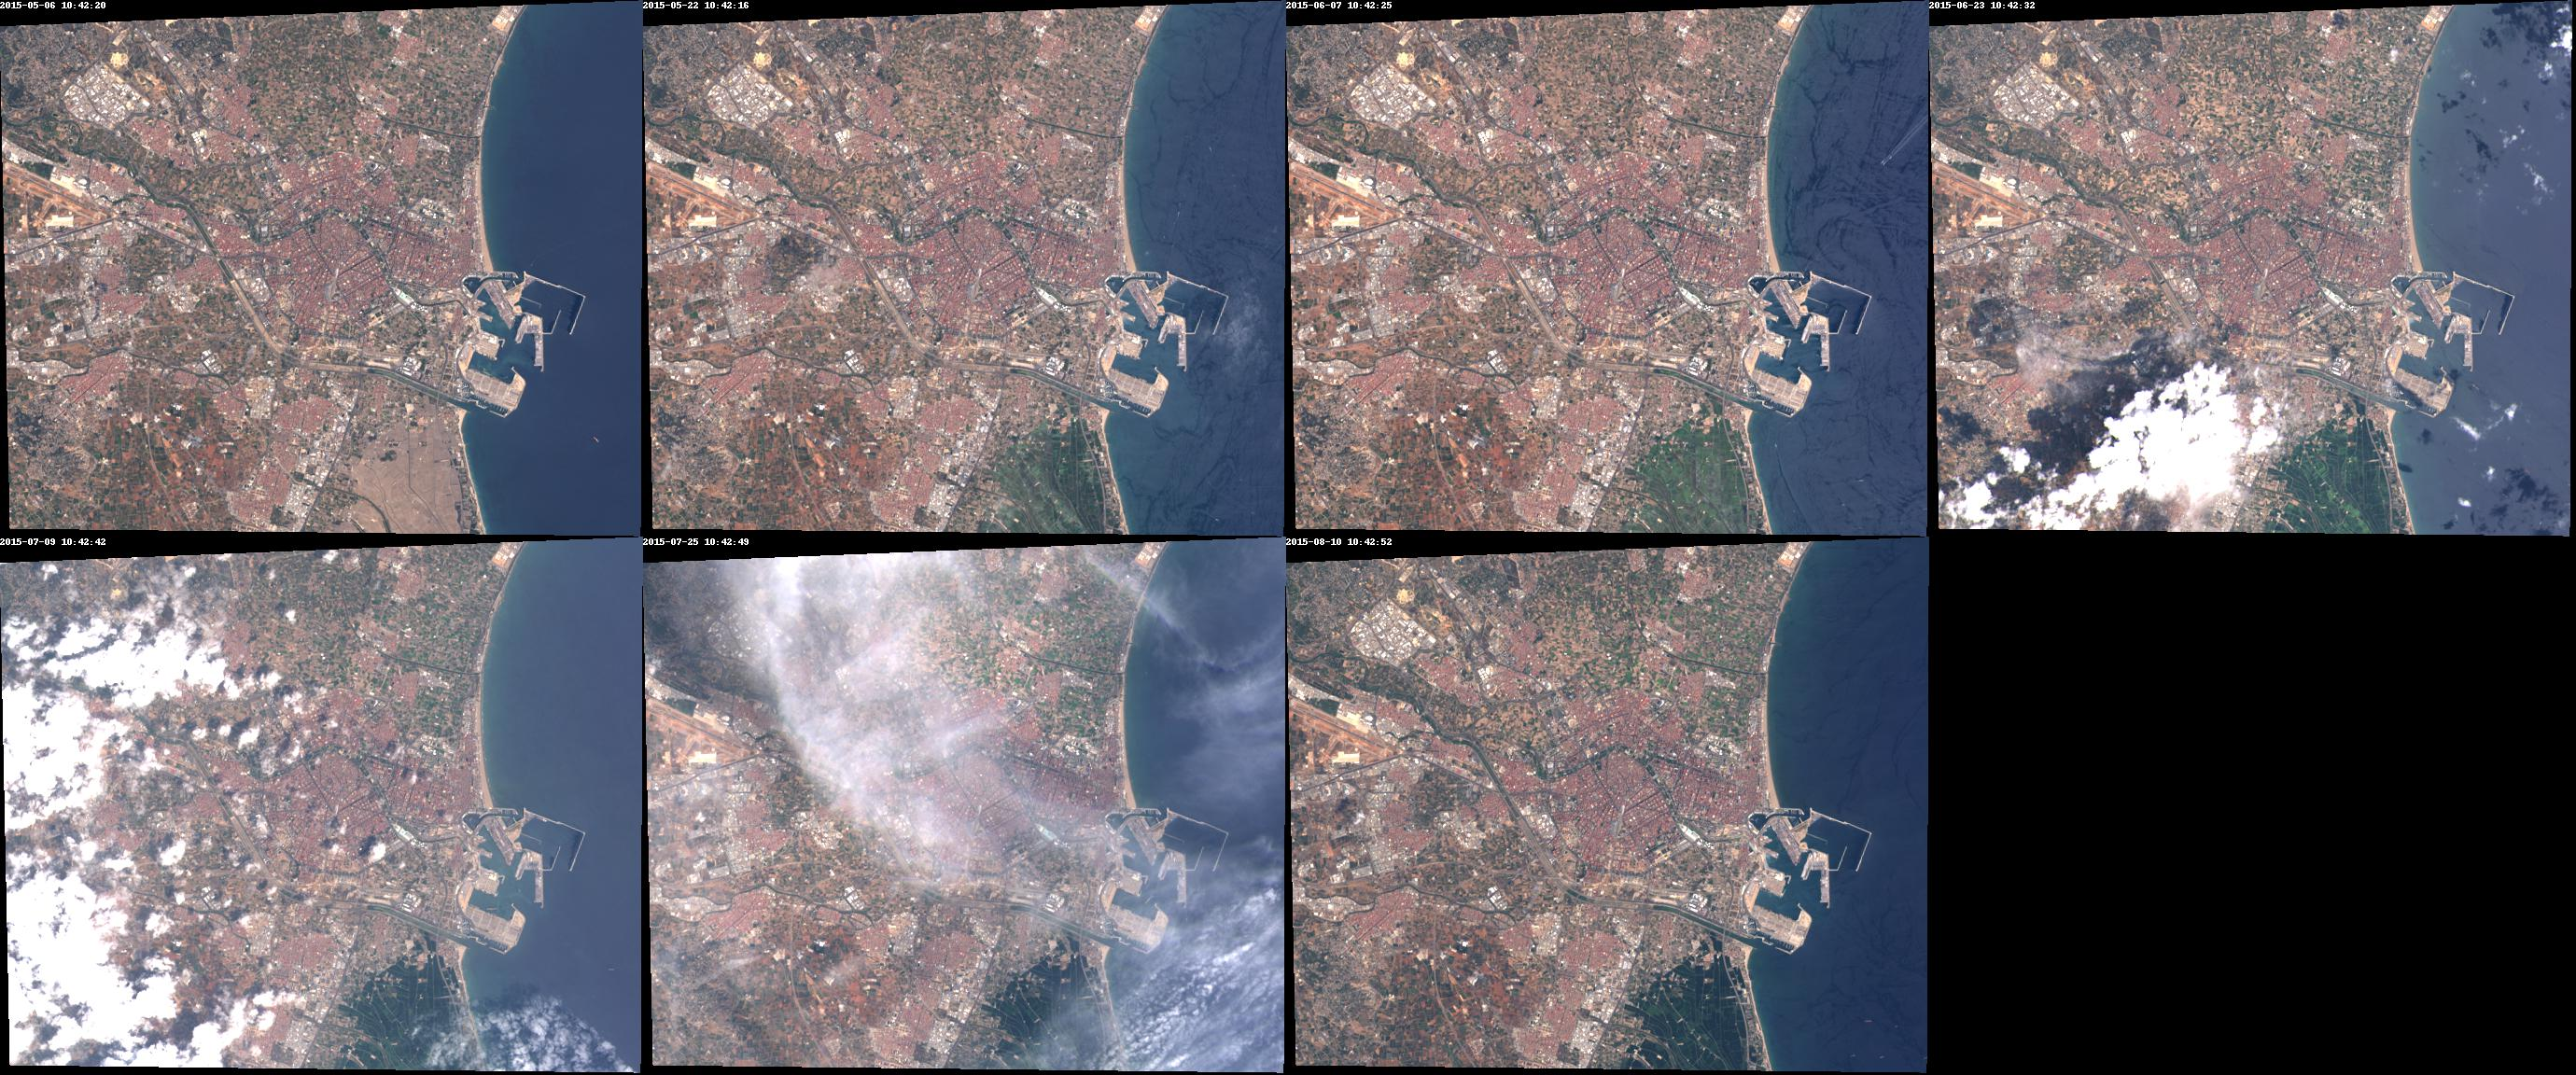

In [4]:

image_wrap = image_wrapper.L8L1TImage(image_index,image_collection_name)

imcoll = multitemporal_cloud_masking.PreviousImagesWithCC(image_wrap,
                                                          region_of_interest=region_of_interest,
                                                          NUMBER_IMAGES=8)

# print(imcoll.size().getInfo())

def recortar(img):
    return img.clip(region_of_interest)

image_col = download.DownloadImageCollectionThumb(imcoll.map(recortar),
                                                  params={"format":"png","bands":"B4,B3,B2","max":.3},
                                                  image_name_prepend="previous_images")

#concat all images
imagenes_previas = image_col.image_name
imagen = download.MosaicImageList(imagenes_previas,[2,4])


display(Image(imagen),Caption('Previous Landsat images (first 11 images) and image of interest (last image)'))

Additionally, we can show the cloud cover (CC) of the time series in a table (Table 1) or plot (Figure 3).

In [5]:
featurecol = converters.eeImageCollectionToPandas(imcoll,["system:time_start","CC","system:index"])

featurecol

,system:index,CC,system:time_start,.geo
0,LC08_199032_20150506,0.214747,2015-05-06 10:42:20.982,NaN
1,LC08_199032_20150522,0.203866,2015-05-22 10:42:16.450,NaN
2,LC08_199032_20150607,0.132566,2015-06-07 10:42:25.740,NaN
3,LC08_199032_20150623,7.309632,2015-06-23 10:42:32.430,NaN
4,LC08_199032_20150709,21.169967,2015-07-09 10:42:42.931,NaN
5,LC08_199032_20150725,39.733338,2015-07-25 10:42:49.256,NaN
6,LC08_199032_20150810,0.037235,2015-08-10 10:42:52.996,NaN


Table 1. Cloud cover of first 5 images shown on Fig. 2.

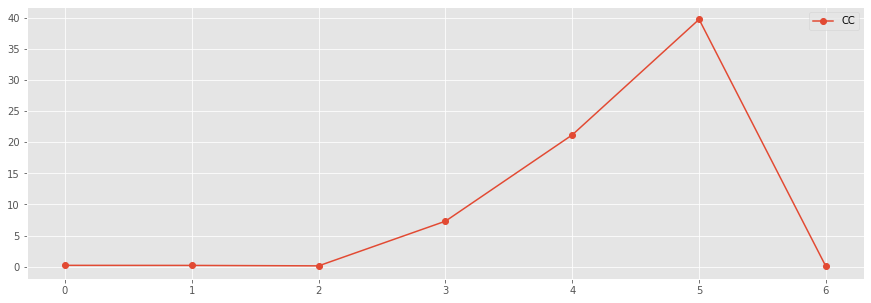

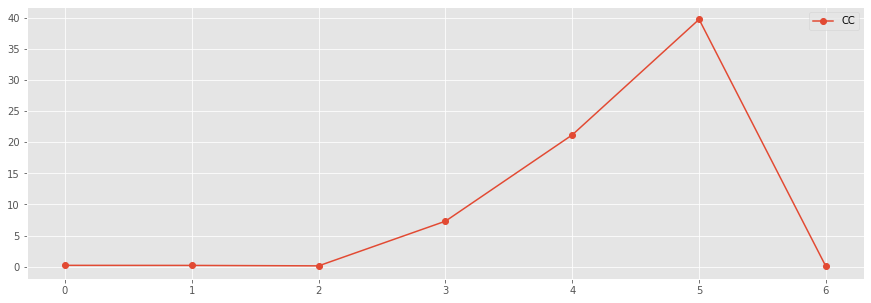

In [6]:
import matplotlib.style
import matplotlib.pyplot as plt
import pandas as pd

matplotlib.style.use('ggplot')
ax = featurecol[['CC']].plot(figsize=(15,5),style="-o")
display(plt.gcf(),
        Caption("Cloud cover of the image time series shown on Fig. 2."))

### Image selection 

The function `SelectImagesTraining` automatically selects the most recent images without clouds (`num_images`) within the current Landsat 8 image collection using the cloud cover calculated from the QABand. It creates a new image (image_with_lags) by stacking the cloudy image and the previous cloud-free images (e.g. max_lags=3).


In [7]:
# Select a number of scenes (max_lags) previous to the selected images and stack all those images together with this on bands
# from imp import reload
# reload(multitemporal_cloud_masking)
# reload(image_wrapper)
max_lags = 3 
image_with_lags = multitemporal_cloud_masking.SelectImagesTraining(image_wrap,
                                                                   region_of_interest=region_of_interest,
                                                                   num_images=max_lags,
                                                                   threshold_cc=5)


#### Show selected images and its dates
`image_with_lags` contains the image of interest together with its previously selected cloud-free images (lags) from the time series. Properties of each image are included on the metadata. As an example we show how to provide the acquisition dates:

In [8]:
keys_time_stamps = ["system:time_start"]+["system:time_start_lag_"+str(lag) for lag in range(1,max_lags+1)]+ ["CC_lag_%d" % lag for lag in range(1,max_lags+1)]

# Print time stamps 
dictionary_server = {}
for prop in keys_time_stamps:
    dictionary_server[prop] = image_with_lags.get(prop)

dict_local = ee.Dictionary(dictionary_server).getInfo()
dict_local

{'CC_lag_1': 0.03723459246181982,
 'CC_lag_2': 0.13256571216903226,
 'CC_lag_3': 0.2038659956065596,
 'system:time_start': 1440585780480,
 'system:time_start_lag_1': 1439203372996,
 'system:time_start_lag_2': 1433673745740,
 'system:time_start_lag_3': 1432291336450}

And how to show the selected time series: 

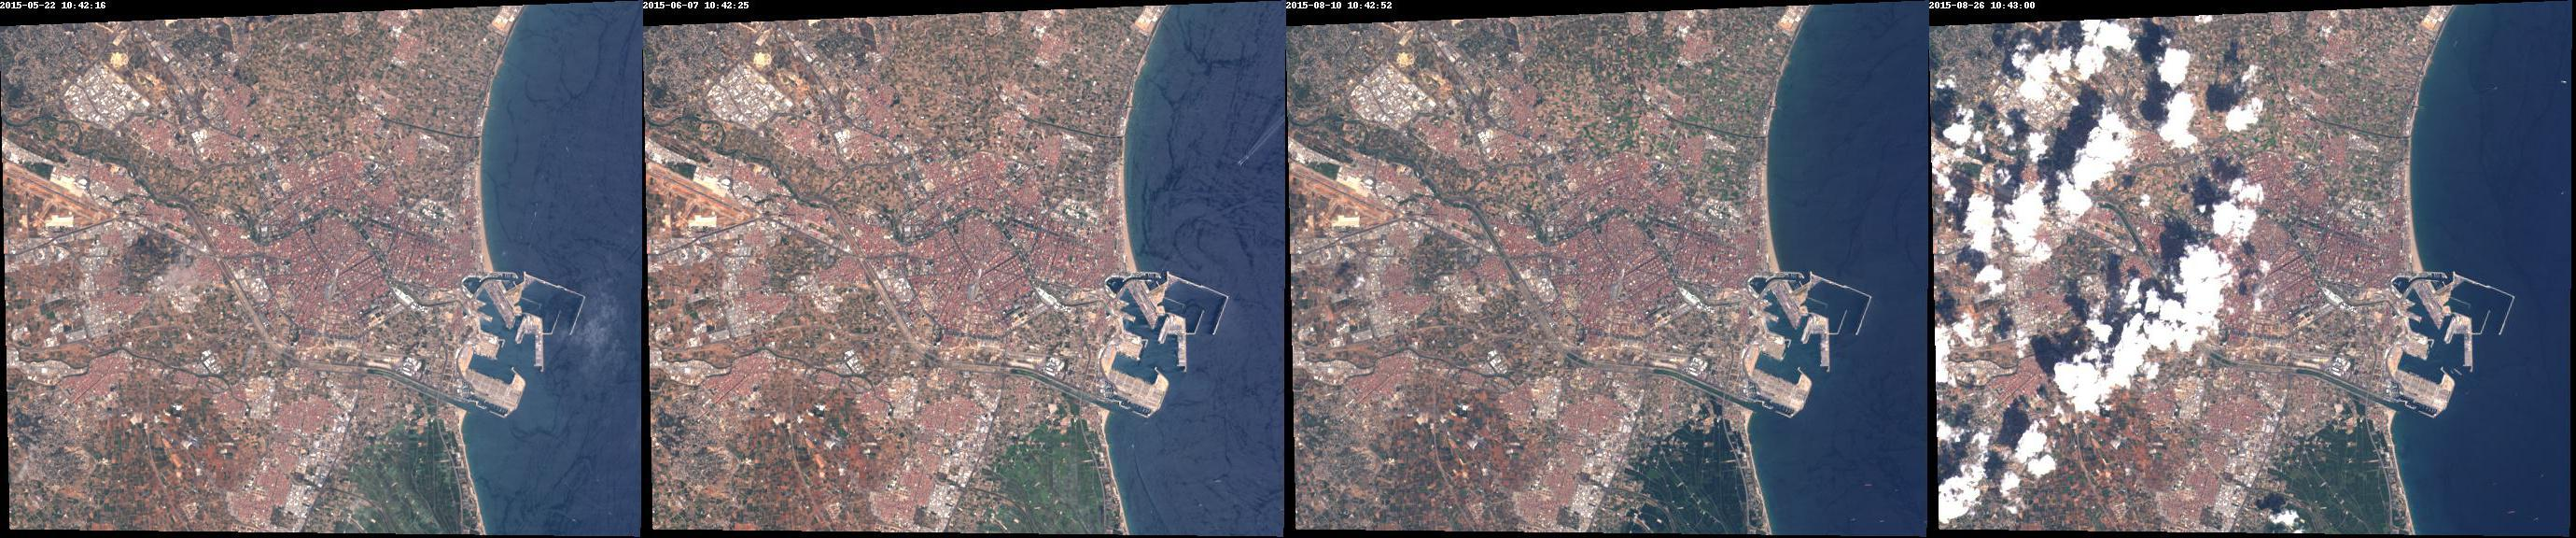

In [9]:
# Show "image": lag_3,lag_2,lag_1 and current image:
img_file = time_series_show.ShowLaggedThumbs(image_with_lags.clip(region_of_interest),
                                             range(0,max_lags+1),
                                             bands=["B4","B3","B2"],
                                             params={"max":.3})

display(Image(img_file),Caption(' Cloudy image to process (right) together with its '+
                                'chosen previous images sorted by time acquisition: '+
                                'lag_3 (left), lag_2 (second left), lag_1 (third left)'))

###  Precomputed cloud mask for Estimation

The model, detailed in [Gómez-Chova et al. 2017](http://dx.doi.org/10.1117/1.JRS.11.015005), makes use of a preliminary cloud mask in order to select only cloud-free pixels to fit a model and estimate a background cloud-free image for the date of interest. The proposed method not only tries to improve the final cloud mask but also the estimated cloud-free image. We will use the `QABand` of Landsat which includes a preliminary cloud mask. This cloud mask is dilated (using a growing of 3-pixels in order to avoid misclassified pixels in the boundaries of the clouds) to get the pre-computed cloud mask used for estimation in the proposed model.

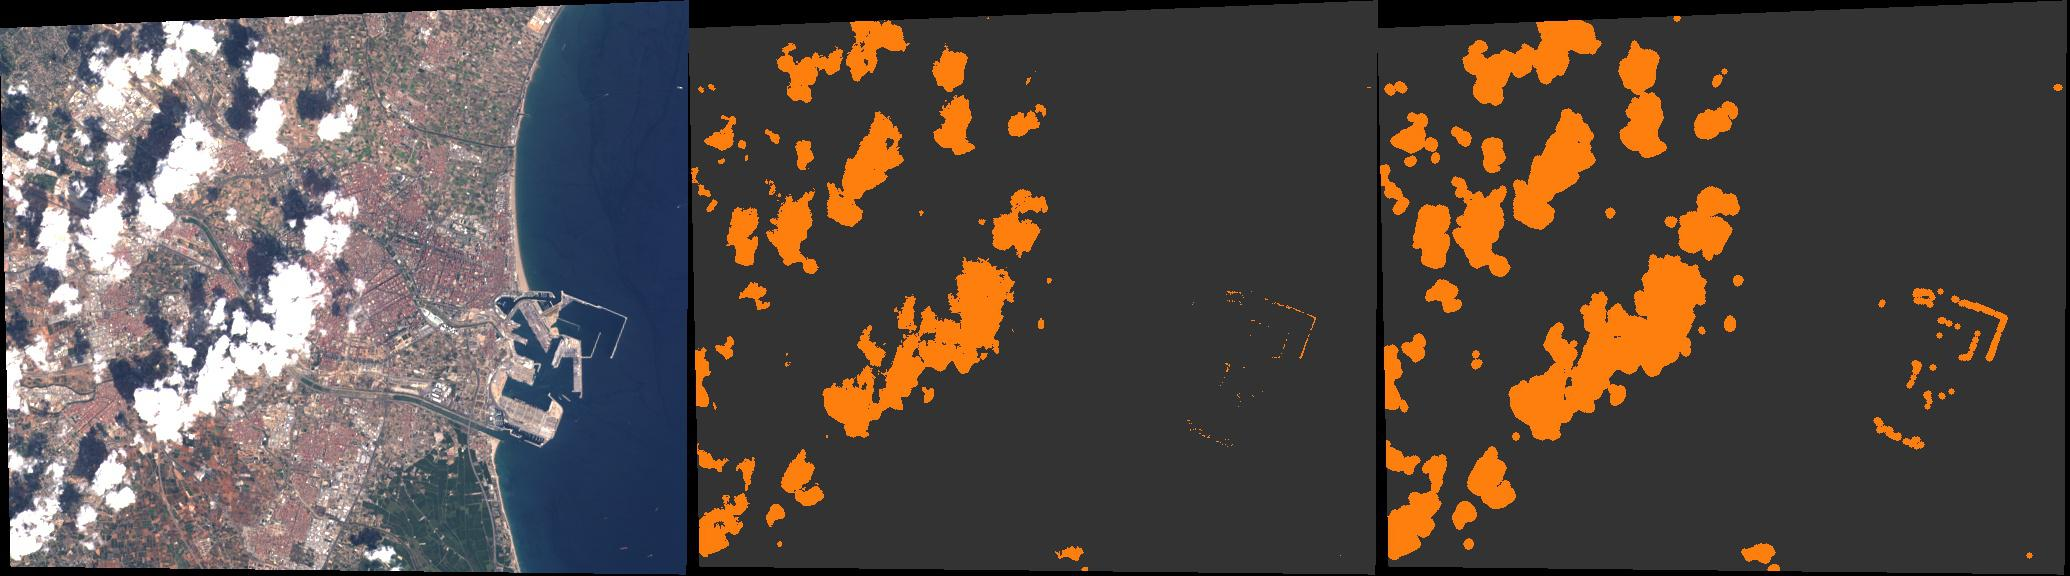

In [10]:
clouds_original = image_predict_clouds.select('BQA').bitwiseAnd(int('0000000000010000',2)).gt(0)
#clouds_original = image_predict_clouds.select("fmask").eq(2)
#clouds_original = clouds_original.where(image_predict_clouds.select("fmask").eq(4),2)

# Add growing to the mask

clouds = clouds_original.reduceNeighborhood(ee.Reducer.max(),
                                            ee.Kernel.circle(radius=3))

clouds_file = download.MaybeDownloadThumb(clouds.clip(region_of_interest),
                                          params={'max':1,'min':0,
                                                  'palette':','.join(['333333','ff7f0e'])})
clouds_file_original = download.MaybeDownloadThumb(clouds_original.clip(region_of_interest),
                                                   params={'max':1,'min':0,
  'palette':','.join(['333333','ff7f0e'])})

name_composite_images = download.MosaicImageList([image_file_original,clouds_file_original,clouds_file],
                                                 [1,3])

display(Image(name_composite_images),
        Caption('Original image (right), Cloud mask from the QABand (center), 3-pixel dilated mask (right).'))


# Fitting the model and predicting the background

Given the image with its lags $Y_t$, we will form 2 different data sets:

Collection for prediction P:  
* Training dataset: $X_P=X_{t-2}, X_{t-3}$, and $Y_P=X_{t-1}$
* Test dataset: $X_P=X_{t-1}, X_{t-2}$, and $Y_P=X_{t}$

Collection for estimation E:  
- Training dataset: $X^\mathcal{C}_E=X_{t-1}^\mathcal{C}, X_{t-2}^\mathcal{C}$, $Y^\mathcal{C}_E=X_{t}^\mathcal{C}$, where $\mathcal{C}$ is a subset of $m$ clear pixels in ${X}_t$ obtained from the Landsat QABand cloud mask.
- Test dataset: $X_E=X_{t-1}, X_{t-2}$, and $Y_E=X_{t}$

The model we want to optimize is:
$$
\mathcal{L}(W) = \frac{\beta}{n}||(X_P W-Y_P)||^2 + \frac{1-\beta}{m}||X_E W-Y_E||^2 + \lambda||W||^2
$$
Which can be written as: 
$$
\mathcal{L}(W) = \left \| diag\begin{pmatrix} \frac{\beta}{n} \\ \frac{1-\beta}{m} \end{pmatrix}^{1/2} \begin{pmatrix}  X_P \\  X_E \end{pmatrix} W - diag\begin{pmatrix} \frac{\beta}{n} \\ \frac{1-\beta}{m} \end{pmatrix}^{1/2} \begin{pmatrix} Y_P \\ Y_E \end{pmatrix} \right \|^2+ \lambda||W||^2
$$


The `ModelCloudMasking` class creates the two datasets for estimation and prediction as described before. It takes as inputs the image with its lags or previous images ($Y_t$) and the cloud mask for estimation. 

Figure 5 shows the images used for prediction (top) and the ones used for estimation (bottom).. They correspond to `lag_3`,`lag_2`, `lag_1` for prediction and `lag_2`, `lag_1`, `original_img` for estimation.


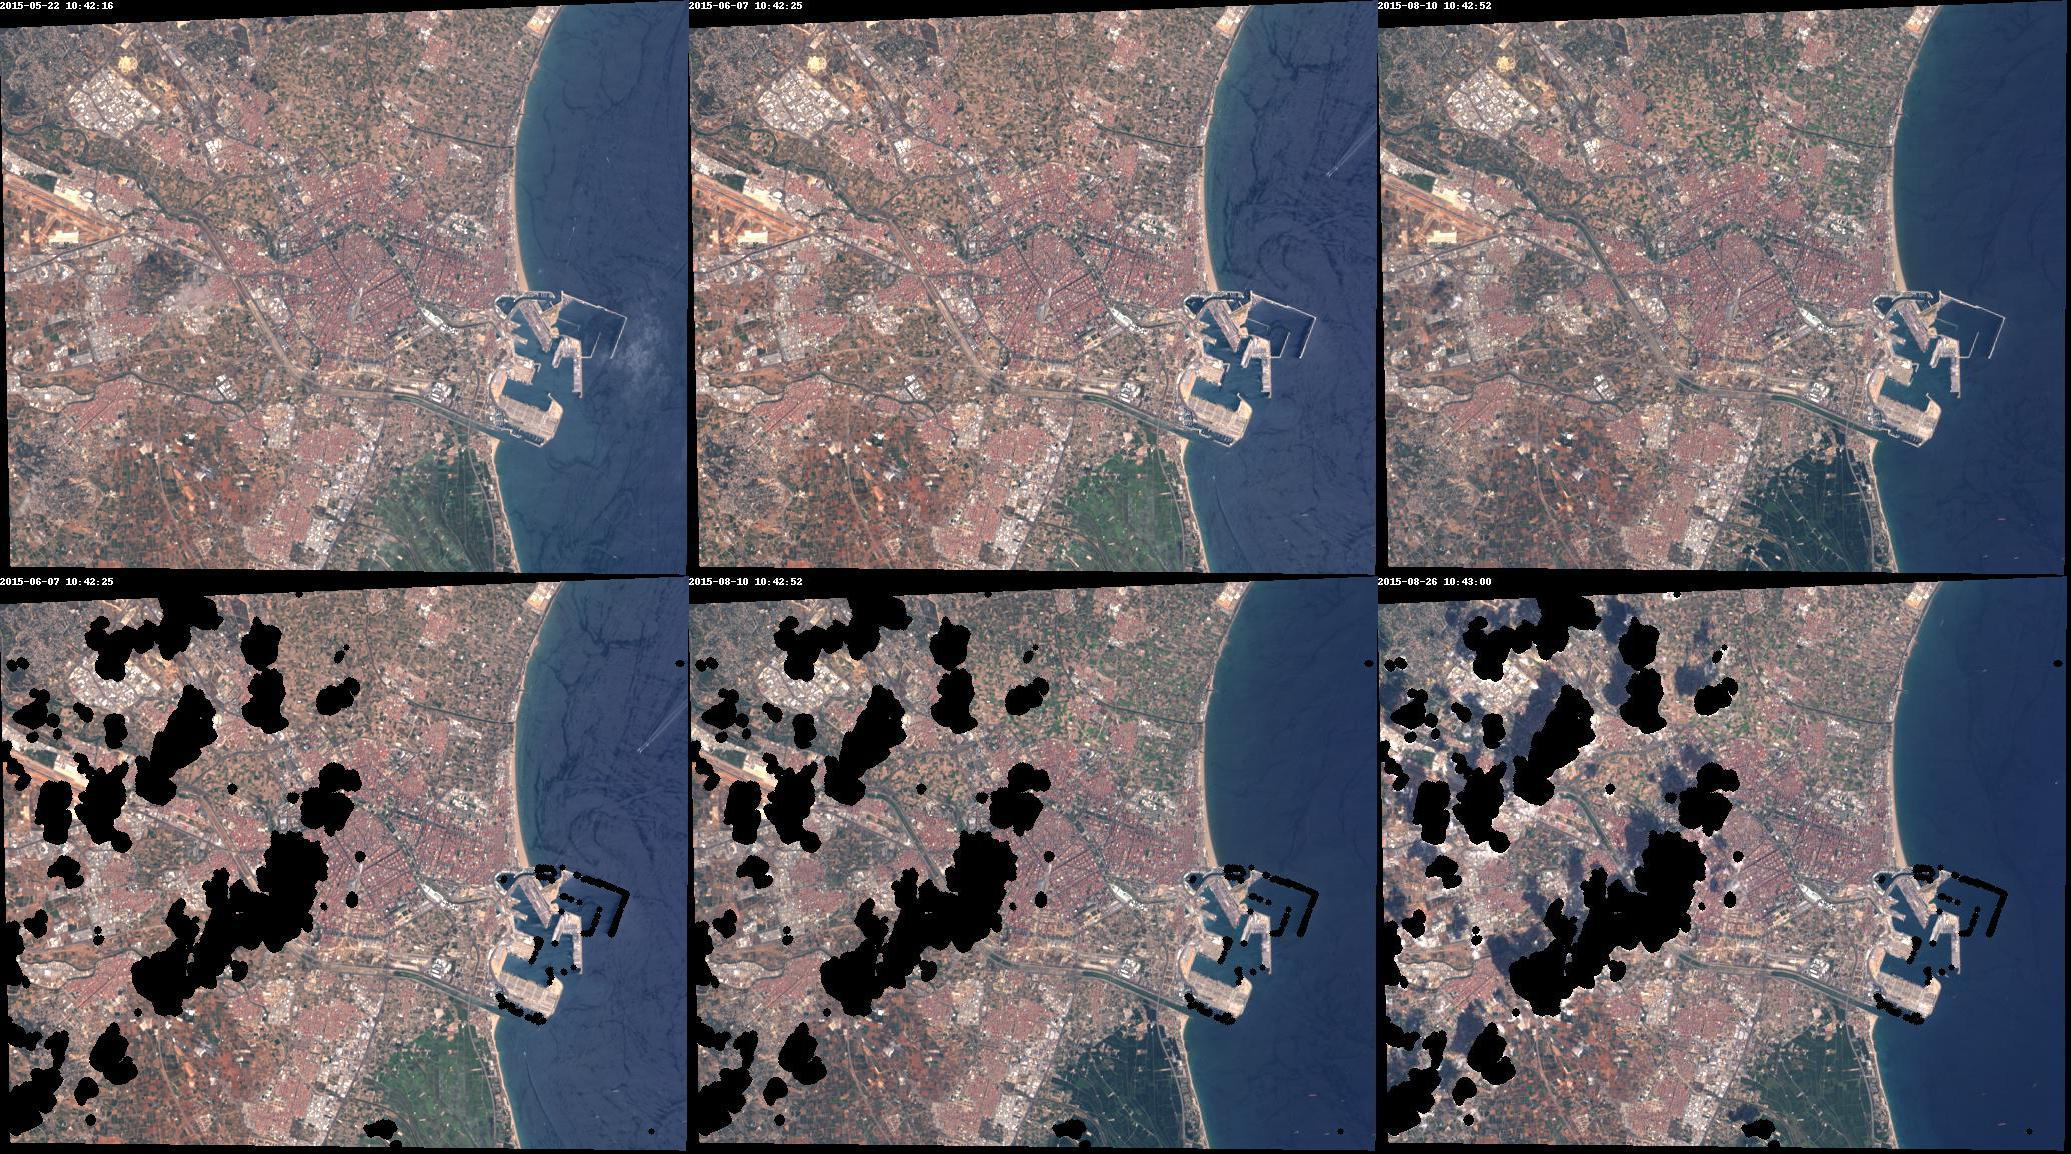

In [11]:
bands_model = ["B1","B2", "B3", "B4", "B5", "B6", "B7","B9","B10", "B11"]
modelo = multitemporal_cloud_masking.ModelCloudMasking(image_with_lags,bands_model,
                                                       clouds,max_lags,region_of_interest)

img_file_pred = time_series_show.ShowLaggedThumbs(image_with_lags.clip(region_of_interest),
                                                 range(1,max_lags+1),
                                                 bands=["B4","B3","B2"],
                                                 params={"max":.3})
img_file_est = time_series_show.ShowLaggedThumbs(modelo.img_est.clip(region_of_interest),
                                                 range(0,max_lags),
                                                 bands=["B4","B3","B2"],
                                                 params={"max":.3})

img_files_pred_est = download.MosaicImageList([img_file_pred,img_file_est],
                                              [2,1])
display(Image(img_files_pred_est),
        Caption('Images for prediction (top). '+
                'Images for estimation with the grown cloud mask from the QABand (bottom). '+
                'Note that a different image set is used on each row, lag_3, lag_2, lag_1 for prediction and lag_2, lag_1, original_img for estimation. Additionally, we can observe in the images used for estimation that we also mask the cloudy pixels in all the previous images.'))


Finally, we need to train and predict the cloud-free background image using the Linear and Kernel Ridge Regression methods. We use four main functions: `TrainLinearServer`, `TrainRBFKernelServer`, `PredictLinear` and `PredictRBFKernel` to train and predict the proposed models. This process requires computationally expensive invocations that the current GEE does not allow running on *interactive mode*. Thus they have been executed as an `Export` task on *batch mode*. 

### Kernel Ridge Regression Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Create a folder called ee_ipl_uv_downloads inyour google drive
!mkdir '/content/drive/My Drive/ee_ipl_uv_downloads'

In [12]:
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s')

2018-04-26 14:22:02 ee_ipl_uv.download INFO     Elapsed: 0s Status: READY
2018-04-26 14:22:46 ee_ipl_uv.download INFO     ee.task COMPLETED 40s. Starting download from Google Drive
2018-04-26 14:22:47 ee_ipl_uv.download INFO     Downloading image pandas_ftcoltm9egyta.csv from drive
2018-04-26 14:22:48 ee_ipl_uv.multitemporal_cloud_masking INFO     Size of downloaded ds: (28, 36)
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/gonmagar/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


2018-04-26 14:22:48 ee_ipl_uv.model_sklearn INFO     MAE: 0.0727 MSE: 0.0509
2018-04-26 14:22:48 ee_ipl_uv.multitemporal_cloud_masking INFO     Best params: {'alpha': 0.000620967265569577, 'gamma': 0.014673760036211934}


[Parallel(n_jobs=3)]: Done 150 out of 150 | elapsed:    0.3s finished


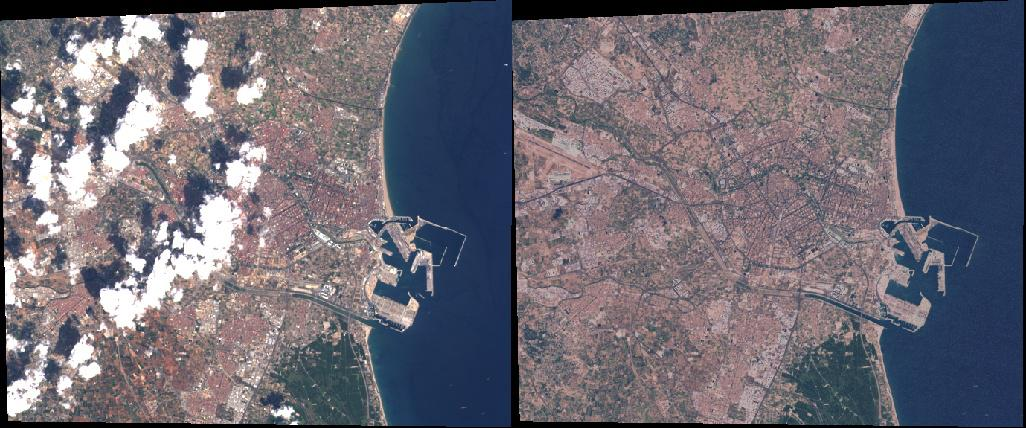

In [13]:
modelo = multitemporal_cloud_masking.ModelCloudMasking(image_with_lags,bands_model,
                                                       clouds,max_lags,region_of_interest)

lmbda_kernel = 0.001
gamma_kernel = 0.01

modelo.TrainRBFKernelLocal(sampling_factor=None,numPixels=40,lmbda=lmbda_kernel,gamma=gamma_kernel,
                           with_task=True,with_cross_validation=True,mounted_drive=True)

img_forecast_kernel = modelo.PredictRBFKernel()

pred_kernel_file = download.MaybeDownloadThumb(img_forecast_kernel.clip(region_of_interest),
                                               params={
                                                       "bands":"B4_forecast,B3_forecast,B2_forecast",
                                                       "max":.3})

img_files_pred_krr = download.MosaicImageList([image_file_original,pred_kernel_file],
                                              [1,2])

display(Image(img_files_pred_krr),
        Caption('Acquired Landsat 8 image (left) and estimated cloud-free image with the RBF Kernel Ridge Regression model (right)'))

### Linear Ridge Model
Next, we also train the linear ridge regression model and apply it to the image of interest to get also the predicted cloud-free image.

2018-04-26 14:23:05 ee_ipl_uv.download INFO     Elapsed: 0s Status: READY
2018-04-26 14:24:11 ee_ipl_uv.download INFO     Elapsed: 60s Status: RUNNING
2018-04-26 14:24:33 ee_ipl_uv.download INFO     ee.task COMPLETED 80s. Starting download from Google Drive
2018-04-26 14:24:33 ee_ipl_uv.download INFO     Downloading image pandas_ftcolv5q9tzv0.csv from drive
2018-04-26 14:24:36 ee_ipl_uv.multitemporal_cloud_masking INFO     Size of downloaded ds: (31654, 36)
2018-04-26 14:24:36 ee_ipl_uv.model_sklearn INFO     MAE: 0.1239 MSE: 0.1579


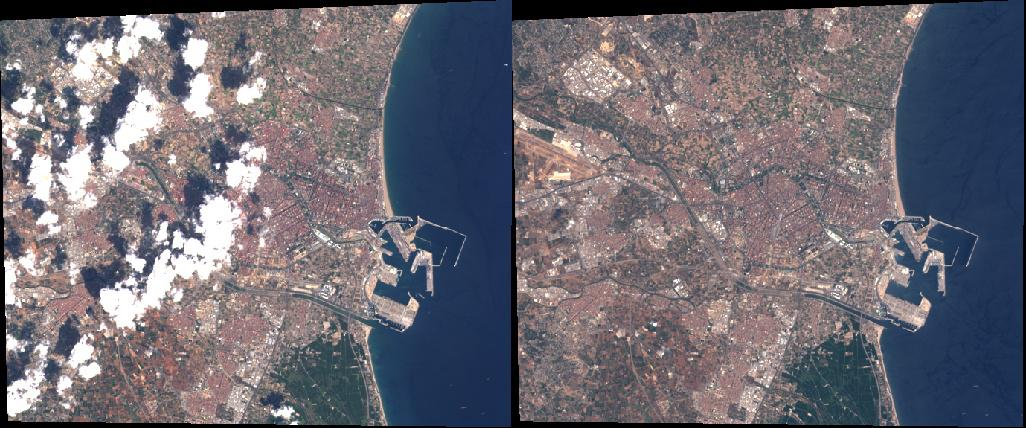

In [14]:
modelo = multitemporal_cloud_masking.ModelCloudMasking(image_with_lags,bands_model,
                                                       clouds,max_lags,region_of_interest)

modelo.TrainLinearLocal(sampling_factor=.05,lmbda=1e-6,with_task=True,mounted_drive=True)

img_forecast_linear = modelo.PredictLinear()

pred_linear_file = download.MaybeDownloadThumb(img_forecast_linear.clip(region_of_interest),
                                               params={"bands":"B4_forecast,B3_forecast,B2_forecast",
                                                       "max":.3})
img_files_pred_linear = download.MosaicImageList([image_file_original,pred_linear_file],
                                                 [1,2])
display(Image(img_files_pred_linear),
        Caption('Acquired Landsat 8 image (left) and estimated cloud-free image with the Linear Ridge Regression model (right)'))

# Clustering the differences to create the cloud mask

We will perform a simple k-means clustering over the difference between the estimated image and the acquired image.  Then we will set a threshold over the cluster centers to classify each cluster as clear, shadow and cloudy (encoded as 0,1 and 2 respectively).

In [17]:
from ee_ipl_uv import clustering

reflectance_bands_landsat8 = ["B%d" % i for i in range(1, 12) if i != 8]
forecast_bands_landsat8 = [i + "_forecast" for i in reflectance_bands_landsat8]

img_forecast = img_forecast_linear

clusterscore = clustering.ClusterClouds(image_with_lags.select(reflectance_bands_landsat8),
                                        img_forecast,
                                        region_of_interest=region_of_interest)


### Cloud Mask visualization

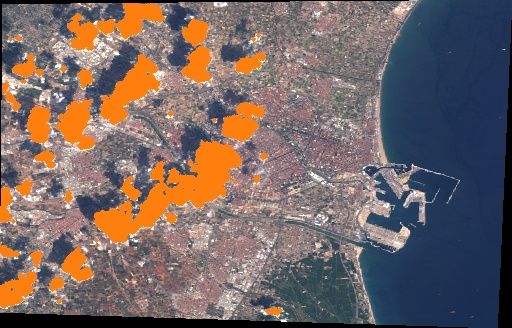

In [19]:
imageRGB = image_predict_clouds.visualize(max=.3,bands=["B4","B3","B2"])

clusterscore = clusterscore.updateMask(clusterscore)
cloud_score_threshold_vis = clusterscore.visualize(max=1,min=0,palette=['1f77b4', 'ff7f0e'])
mosaic = ee.ImageCollection([imageRGB, cloud_score_threshold_vis]).mosaic()
mosaic_clouds_file = download.MaybeDownloadThumb(mosaic.clip(region_of_interest))

display(Image(mosaic_clouds_file),
        Caption("Cluster cloud mask over rgb bands"))

Finally, this notebook shows an illustrative example but in order to check the proposed method, we have processed the years 2015 and 2016 for the same region of interest. Results of the processed image time series are showed [here](http://isp.uv.es/projects/cdc/GEE_cloud_detection_results.html).